## Notebook for anlyzing simulated data
Useful for testing visualizations for `cycling_rnn_plotter.py`

In [308]:
param_grid = {}
param_grid['activation'] = ['tanh', 'linear']
param_grid['beta1'] = np.concatenate((np.array([0]), np.logspace(-7, -2, 21)), axis=0)
param_grid['beta2'] = np.concatenate((np.array([0]), np.logspace(-5, 0, 21)), axis=0)
param_grid['stddev_state'] = np.concatenate((np.array([0]), np.logspace(-5, 0, 21)), axis=0)
param_grid['stddev_out'] = np.concatenate((np.array([0]), np.logspace(-4, 1, 21)), axis=0)
param_grid['monkey'] =['D']
param_grid['num_neurons'] = np.concatenate((np.array([100]).astype(int), np.round(np.logspace(1, 3, 21)).astype(int)), axis=0)

val_lengths = [len(v) for k, v in sorted(param_grid.items())]

# Make a copy of param_grid to export to matlab.
param_grid_matlab = copy.deepcopy(param_grid)
param_grid_matlab['val_lengths'] = val_lengths
param_grid_matlab['sorted'] = sorted(param_grid)

# val_lengths ordered by keys
# Important: apparently ParameterGrid() orders lexicographically based on keys.

# Split param_grid to search along hyperparameter axes only
param_grid = parameter_grid_split(param_grid)
len(ParameterGrid(param_grid))

107

In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [20]:
import numpy as np
import scipy.io as sio
import sklearn as sk
from sklearn.grid_search import ParameterGrid
from sklearn import decomposition
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import datetime
import pickle
import os
import pprint
from cycling_rnn import *
import pprint as pp

## Plot settings

In [3]:
cmap = sns.color_palette('RdBu',5)[:2] + sns.color_palette('RdBu',5)[-2:]
sns.set_palette(cmap)
sns.set_context('paper', font_scale=1.5)

### Load stuff

In [4]:
RUN = './saves/9-12-C/'
param_grid = pickle.load(open(RUN+'npsaves/param_grid.pickle', 'rb'))

In [6]:
val_lengths = []
for p in range(len(param_grid)):
    val_lengths.append([len(v) for k, v in sorted(param_grid[p].items())])
val_lengths

[[1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1],
 [1, 21, 1, 1, 1, 1, 1],
 [1, 1, 21, 1, 1, 1, 1],
 [1, 1, 1, 1, 21, 1, 1],
 [1, 1, 1, 1, 1, 21, 1],
 [1, 1, 1, 1, 1, 1, 21]]

In [7]:
cum_lengths = np.cumsum([np.prod(val_lengths[p]) for p in range(len(val_lengths))])
print cum_lengths-1

[  0   1  22  43  64  85 106]


In [8]:
keys = sorted(param_grid[0].keys())
keys

['activation',
 'beta1',
 'beta2',
 'monkey',
 'num_neurons',
 'stddev_out',
 'stddev_state']

In [14]:
sim = 5
cur_params = ParameterGrid(param_grid)[sim]
cur_params

{'activation': 'tanh',
 'beta1': 5.6234132519034904e-07,
 'beta2': 0.0,
 'monkey': 'C',
 'num_neurons': 100,
 'stddev_out': 0.0,
 'stddev_state': 0.0}

In [15]:
# List directory
# Number of sims in RUN
total_sims = len(os.listdir(RUN+'tb'))

# load x and y data
x = np.load(RUN+'npsaves/'+str(sim)+'x.npy')
y = np.load(RUN+'npsaves/'+str(sim)+'y.npy')
#os.listdir(RUN+'npsaves')

cur_params = ParameterGrid(param_grid)[sim]

In [17]:
if cur_params['monkey']=='D':
    data = sio.loadmat('/Users/jeff/Documents/Python/_projects/cyclingRNN/drakeFeb_processed.mat')
else:
    data = sio.loadmat('/Users/jeff/Documents/Python/_projects/cyclingRNN/cousFeb_processed.mat')
    
emg = data['EMG']
m1 = data['M1']

x = x[:emg.shape[0], :emg.shape[1], :]
y = y[:emg.shape[0], :emg.shape[1], :]

### plot stuff

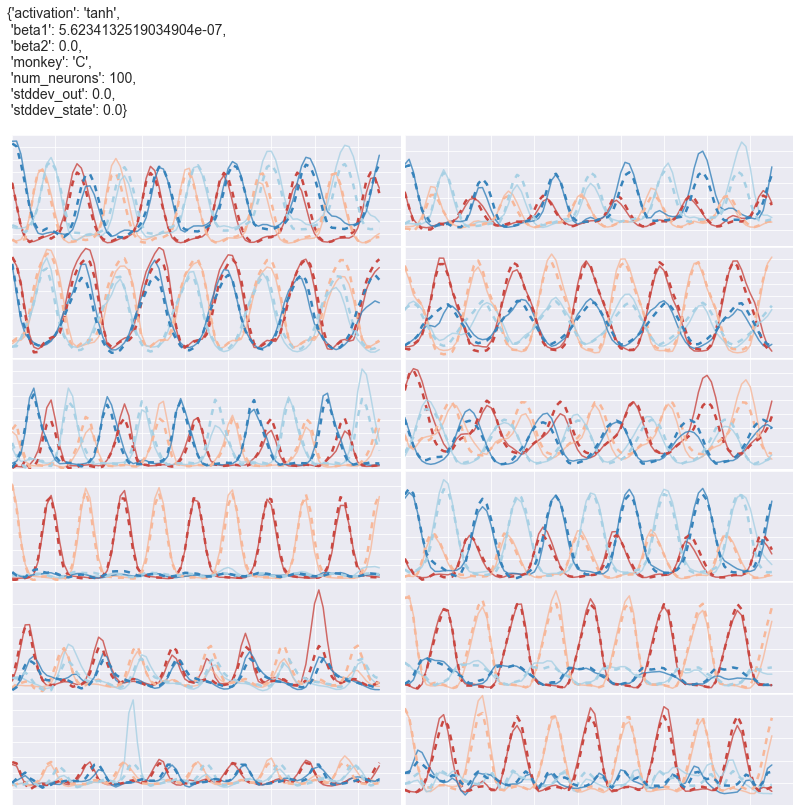

In [21]:
rows = 6
cols = 2

with sns.color_palette(n_colors=4):
    f, ax = plt.subplots(rows,cols, figsize=(14, 12), sharex=True, sharey=False,
                         subplot_kw={'xticklabels':[], 'yticklabels':[]},
                         gridspec_kw={'wspace':0.01, 'hspace':0.01})
    for i in range(rows):
        for j in range(cols):
            muscle = np.ravel_multi_index((i,j), (rows,cols))
            ax[i,j].plot(emg[:,:,muscle], linewidth=1.5, alpha=.8)
            ax[i,j].plot(y[:,:,muscle],'--',linewidth=2.5, alpha=1)
            #ax[i,j].set_title('muscle '+str(muscle))
f.suptitle(pp.pformat(cur_params), fontsize=14, x=0.12, y=0.92, verticalalignment='bottom', horizontalalignment='left')
plt.show()

## RNN neuron PC plots

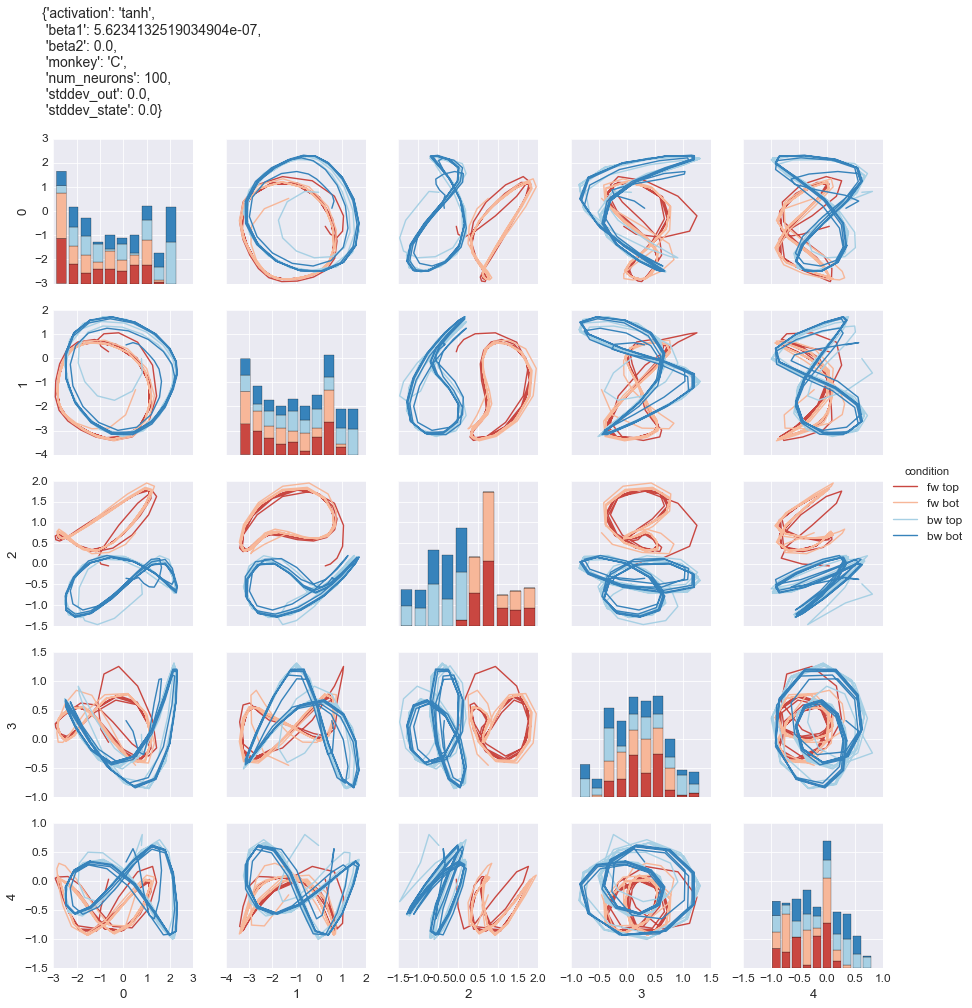

In [22]:
# plot PCs for the RNN state variable
pca_x = sk.decomposition.PCA(n_components=5)
pca_x.fit(np.concatenate([x[:,i,:] for i in range(4)]))
f = make_pairgrid([np.dot(x[:,i,:], pca_x.components_.T) for i in range(4)])
f.fig.suptitle(pp.pformat(cur_params), fontsize=14, x=0.05, y=1.0, verticalalignment='bottom', horizontalalignment='left')

## RNN activations

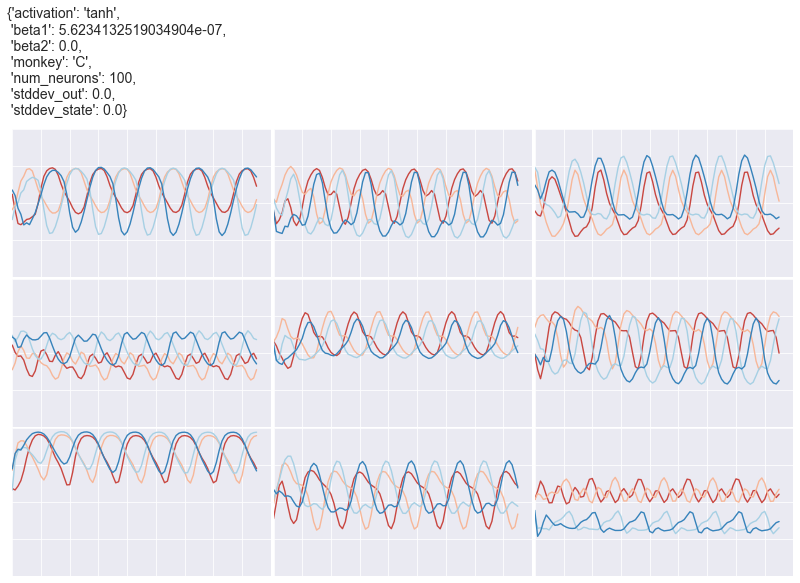

In [23]:
rows = 3
cols = 3
f, ax = plt.subplots(rows,cols, figsize=(14, 8), sharex=True, sharey=True,
                     subplot_kw={'ylim':[-1, 1], 'xticklabels':[], 'yticklabels':[]},
                     gridspec_kw={'wspace':0.01, 'hspace':0.01})

for i in range(rows):
    for j in range(cols):
        neuron = np.ravel_multi_index((i,j), (rows,cols))
        ax[i,j].plot(x[:,:,neuron])
        #ax[i,j].set_title(str(neuron))
f.suptitle(pp.pformat(cur_params), fontsize=14, x=0.12, y=0.92, verticalalignment='bottom', horizontalalignment='left')
plt.show()

## curvature plot

In [261]:
m1_k = np.zeros(m1.shape[:-1])
x_k = np.zeros(x_n.shape[:-1])
emg_k = np.zeros(emg.shape[:-1])
for c in range(4):
    m1_k[:,c] = get_curvature(m1[:,c,:])
    emg_k[:,c] = get_curvature(emg[:,c,:])
    x_k[:,c] = get_curvature(x[:,c,:])

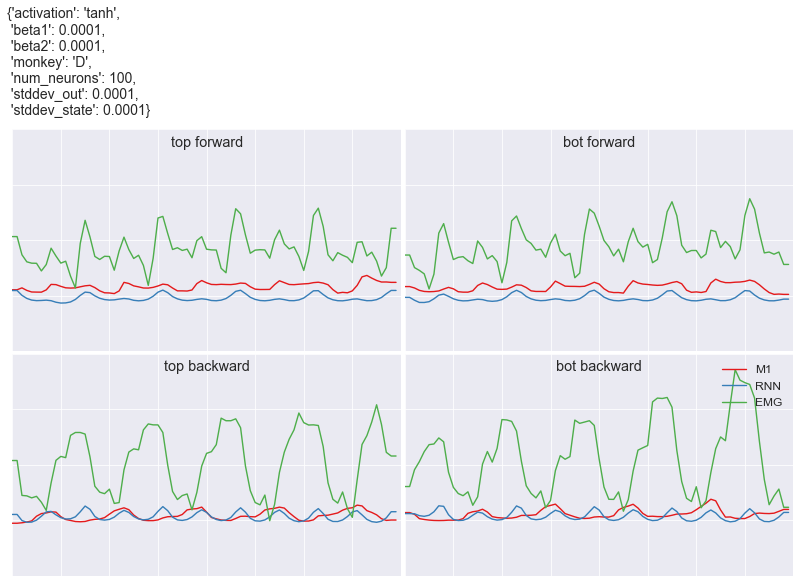

In [284]:
with sns.color_palette('Set1'):
    f, ax = plt.subplots(2,2, figsize=(14, 8), sharex=True, sharey=True,
                         subplot_kw={'ylim':[0, 2], 'xticklabels':[], 'yticklabels':[]},
                         gridspec_kw={'wspace':0.01, 'hspace':0.01})
    ax[0,0].plot(m1_k[:,0])
    ax[0,0].plot(x_k[:,0])
    ax[0,0].plot(emg_k[:,0])
    ax[0,0].set_title('top forward', y=0.9)
    
    ax[0,1].plot(m1_k[:,1])
    ax[0,1].plot(x_k[:,1])
    ax[0,1].plot(emg_k[:,1])
    ax[0,1].set_title('bot forward', y=0.9)
    
    ax[1,0].plot(m1_k[:,2])
    ax[1,0].plot(x_k[:,2])
    ax[1,0].plot(emg_k[:,2])
    ax[1,0].set_title('top backward', y=0.9)

    ax[1,1].plot(m1_k[:,3])
    ax[1,1].plot(x_k[:,3])
    ax[1,1].plot(emg_k[:,3])
    ax[1,1].set_title('bot backward', y=0.9)
    ax[1,1].legend(iter(ax[1,1].get_children()[:3]), ('M1', 'RNN', 'EMG'))

    f.suptitle(pp.pformat(cur_params), fontsize=14, x=0.12, y=0.92, verticalalignment='bottom', horizontalalignment='left')
plt.show()

### Load TF model

In [24]:
TF_PATH = RUN+'tfsaves/'+str(sim)
tf.reset_default_graph()
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph(TF_PATH+'.meta')
    new_saver.restore(sess, TF_PATH)
    Mat = sess.run([v for v in tf.all_variables() if v.name == 'RNN/BasicRNNCellNoise/Linear/Matrix:0'])[0]
    A = Mat[2:]
    B = Mat[:2]

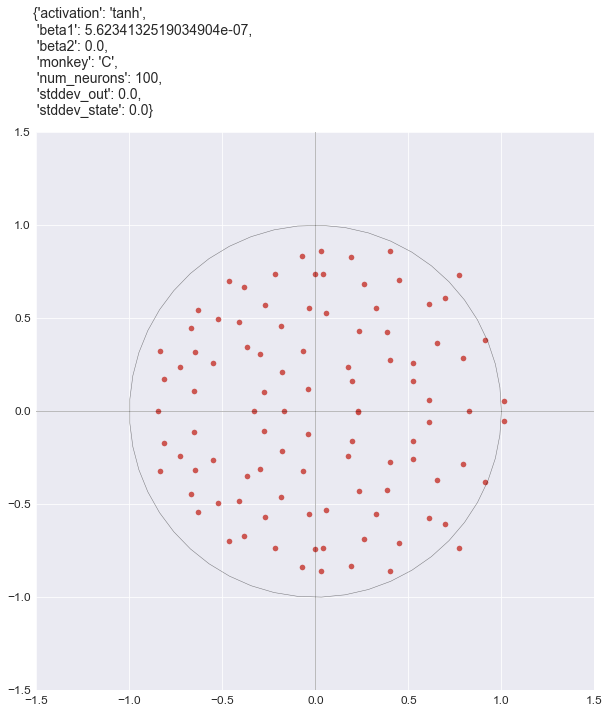

In [25]:
f = plot_eigs(A)
f.suptitle(pp.pformat(cur_params), fontsize=14, x=0.12, y=0.92, verticalalignment='bottom', horizontalalignment='left')

In [26]:
import datetime
import os
import numpy as np
import scipy.io as sio
import pickle
import copy

from cycling_rnn import run_rnn, parameter_grid_split
from sklearn.grid_search import ParameterGrid

import sys


In [36]:
cur_params['activation']

'tanh'

In [37]:
param_grid = {}

param_grid['activation']    = np.random.choice(['tanh'], size=1)
param_grid['beta1']         = 10**np.random.uniform(-7, -3, size=1)
param_grid['beta2']         = 10**np.random.uniform(-5, -2, size=1)
param_grid['stddev_state']  = 10**np.random.uniform(-5, -1, size=1)
param_grid['stddev_out']    = 10**np.random.uniform(-4, 0, size=1)
param_grid['monkey']        = np.random.choice(['C'], size=1)
param_grid['num_neurons']   = np.array([100]).astype(int)

# Split param_grid to search along hyperparameter axes only
cur_params = ParameterGrid(param_grid)[0]

# Fixed parameters
LEARNING_RATE = 0.0003
NUM_ITERS = 10000
LOAD_PREV = False
PREV_PATH = None
LOCAL_MACHINE = True

Y_TF, X_TF = run_rnn(monkey=cur_params['monkey'],
                     beta1=cur_params['beta1'],
                     beta2=cur_params['beta2'],
                     stddev_state=cur_params['stddev_state'],
                     stddev_out=cur_params['stddev_out'],
                     activation=cur_params['activation'],
                     num_neurons=cur_params['num_neurons'],
                     learning_rate=LEARNING_RATE,
                     num_iters=NUM_ITERS,
                     load_prev=LOAD_PREV,
                     local_machine=LOCAL_MACHINE)


  iter: 0000   Loss: 0.128481


FailedPreconditionError: ./saves/.tempstate7924067973449731551
	 [[Node: save/save = SaveSlices[T=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/save/tensor_names, save/save/shapes_and_slices, C, C/Adam, C/Adam_1, RNN/BasicRNNCellNoise/Linear/Bias, RNN/BasicRNNCellNoise/Linear/Bias/Adam, RNN/BasicRNNCellNoise/Linear/Bias/Adam_1, RNN/BasicRNNCellNoise/Linear/Matrix, RNN/BasicRNNCellNoise/Linear/Matrix/Adam, RNN/BasicRNNCellNoise/Linear/Matrix/Adam_1, beta1_power, beta2_power, d, d/Adam, d/Adam_1, x0, x0/Adam, x0/Adam_1)]]
Caused by op u'save/save', defined at:
  File "/Users/jeff/anaconda/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/jeff/anaconda/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-37-dbbc397e1126>", line 31, in <module>
    local_machine=LOCAL_MACHINE)
  File "cycling_rnn.py", line 400, in run_rnn
    saver = tf.train.Saver()
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 848, in __init__
    restore_sequentially=restore_sequentially)
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 516, in build
    save_tensor = self._AddSaveOps(filename_tensor, vars_to_save)
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 212, in _AddSaveOps
    save = self.save_op(filename_tensor, vars_to_save)
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 164, in save_op
    tensor_slices=[vs.slice_spec for vs in vars_to_save])
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/io_ops.py", line 179, in _save
    tensors, name=name)
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 438, in _save_slices
    data=data, name=name)
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 710, in apply_op
    op_def=op_def)
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2297, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/jeff/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1231, in __init__
    self._traceback = _extract_stack()


'C'